In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

import tensorflow as tf
from keras_core import callbacks
import keras_core
import tf_keras as keras
from keras_core import layers
from keras_core import optimizers
from tensorflow_probability import distributions as tfd


Using TensorFlow backend





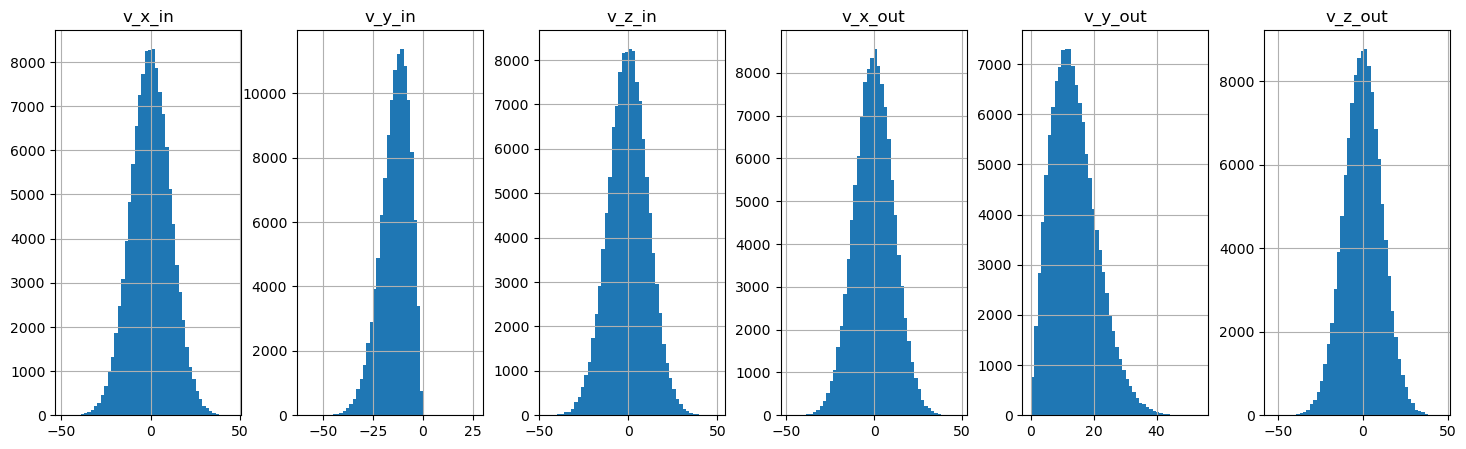

In [55]:
filename = 'D:/OneDrive - TU Eindhoven/Quartile_4/4AI000_Machine learning for Multi-physics modelling and design/Materials_for_ML_assignment_2024/H2_IsoThermalWalls_Sw_0/H2_Vel_MD_Sw_0_B300_Th_300.txt'
names_trans_vel = ['v_x_in', 'v_y_in', 'v_z_in', 'v_x_out', 'v_y_out', 'v_z_out']
df_trans_vel = pd.read_csv(filename, sep= '\s+', header=None, skiprows=[0], names = names_trans_vel).sample(frac = 1)


x = df_trans_vel.loc[:, ].values
x_norm = StandardScaler().fit_transform(x) # normalizing the features

# Creating Dataframe of normalized values
df_trans_vel_norm = pd.DataFrame(x_norm,columns=names_trans_vel)

df_trans_vel.hist(bins = 50, layout= (1,6), figsize= (18,5))

x = df_trans_vel_norm[['v_y_in']].to_numpy()
y = df_trans_vel_norm[['v_y_out']].to_numpy()


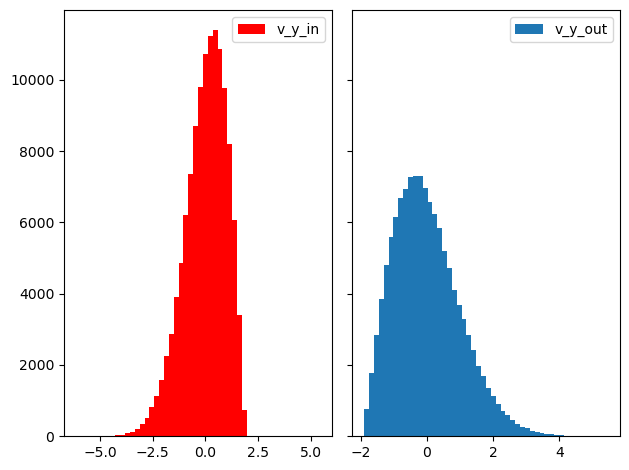

In [56]:
n_bins = 50

fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

# We can set the number of bins with the *bins* keyword argument.
axs[0].hist(x, bins=n_bins, label = 'v_y_in', color = 'r')
axs[1].hist(y, bins=n_bins, label = 'v_y_out')
axs[0].legend()
axs[1].legend()
plt.show()

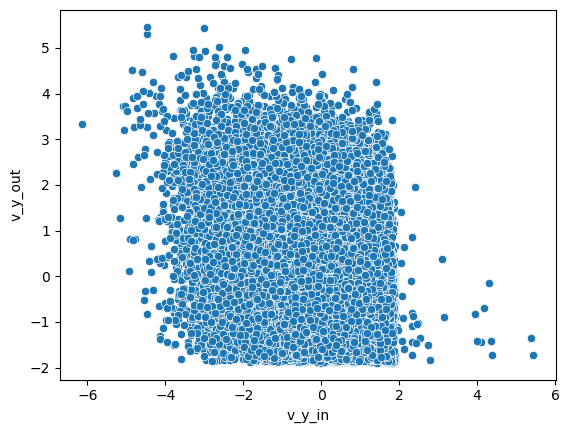

In [57]:
sns.scatterplot(df_trans_vel_norm, x = "v_y_in", y = 'v_y_out')
plt.show()

In [58]:
def elu_plus_one_plus_epsilon(x):
    return keras_core.activations.elu(x) + 1 + keras_core.backend.epsilon()

class MixtureDensityOutput(layers.Layer):
    def __init__(self, output_dimension, num_mixtures, **kwargs):
        super().__init__(**kwargs)
        self.output_dim = output_dimension
        self.num_mix = num_mixtures
        self.mdn_mus = layers.Dense(
            self.num_mix * self.output_dim, name="mdn_mus"
        )  # mix*output vals, no activation
        self.mdn_sigmas = layers.Dense(
            self.num_mix * self.output_dim,
            activation=elu_plus_one_plus_epsilon,
            name="mdn_sigmas",
        )  # mix*output vals exp activation
        self.mdn_pi = layers.Dense(self.num_mix, name="mdn_pi")  # mix vals, logits

    def build(self, input_shape):
        self.mdn_mus.build(input_shape)
        self.mdn_sigmas.build(input_shape)
        self.mdn_pi.build(input_shape)
        super().build(input_shape)

    @property
    def trainable_weights(self):
        return (
            self.mdn_mus.trainable_weights
            + self.mdn_sigmas.trainable_weights
            + self.mdn_pi.trainable_weights
        )

    @property
    def non_trainable_weights(self):
        return (
            self.mdn_mus.non_trainable_weights
            + self.mdn_sigmas.non_trainable_weights
            + self.mdn_pi.non_trainable_weights
        )

    def call(self, x, mask=None):
        return layers.concatenate(
            [self.mdn_mus(x), self.mdn_sigmas(x), self.mdn_pi(x)], name="mdn_outputs"
        )

In [59]:
N_HIDDEN = 50

OUTPUT_DIMS = 1
N_MIXES = 20

mdn_network = keras_core.Sequential(
    [
        layers.Dense(N_HIDDEN, activation="relu"),
        layers.Dense(N_HIDDEN, activation="relu"),
        MixtureDensityOutput(OUTPUT_DIMS, N_MIXES),
    ]
)

In [60]:
def get_mixture_loss_func(output_dim, num_mixes):
    def mdn_loss_func(y_true, y_pred):
        # Reshape inputs in case this is used in a TimeDistributed layer
        y_pred = tf.reshape(
            y_pred,
            [-1, (2 * num_mixes * output_dim) + num_mixes],
            name="reshape_ypreds",
        )
        y_true = tf.reshape(y_true, [-1, output_dim], name="reshape_ytrue")
        # Split the inputs into parameters
        out_mu, out_sigma, out_pi = tf.split(
            y_pred,
            num_or_size_splits=[
                num_mixes * output_dim,
                num_mixes * output_dim,
                num_mixes,
            ],
            axis=-1,
            name="mdn_coef_split",
        )
        # Construct the mixture models
        cat = tfd.Categorical(logits=out_pi)
        component_splits = [output_dim] * num_mixes
        mus = tf.split(out_mu, num_or_size_splits=component_splits, axis=1)
        sigs = tf.split(out_sigma, num_or_size_splits=component_splits, axis=1)
        coll = [
            tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)
            for loc, scale in zip(mus, sigs)
        ]
        mixture = tfd.Mixture(cat=cat, components=coll)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        loss = tf.reduce_mean(loss)
        return loss

    return mdn_loss_func



In [61]:
loss_function = get_mixture_loss_func(OUTPUT_DIMS, N_MIXES)
optimizer = "adam"

mdn_network.compile(loss= loss_function, optimizer= optimizer)

history = mdn_network.fit(
    x,
    y,
    epochs=100,
    batch_size = 256,
    validation_split=0.15,
    shuffle = True,
    callbacks=[
        callbacks.EarlyStopping(monitor="loss", patience=10, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="loss", patience=5),
    ],
)

Epoch 1/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 36s 33ms/step - loss: 1.3746 - val_loss: 1.3320 - learning_rate: 0.0010
Epoch 2/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3432 - val_loss: 1.3315 - learning_rate: 0.0010
Epoch 3/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3461 - val_loss: 1.3304 - learning_rate: 0.0010
Epoch 4/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3416 - val_loss: 1.3293 - learning_rate: 0.0010
Epoch 5/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3403 - val_loss: 1.3297 - learning_rate: 0.0010
Epoch 6/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3416 - val_loss: 1.3292 - learning_rate: 0.0010
Epoch 7/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3435 - val_loss: 1.3293 - learning_rate: 0.0010
Epoch 8/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3397 - val_loss: 1.3293 - learning_rate: 0.0010
Epoch 9/100
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.3418 - val_loss: 1.3289 - learning_rate: 0.0010

### Plot Loss

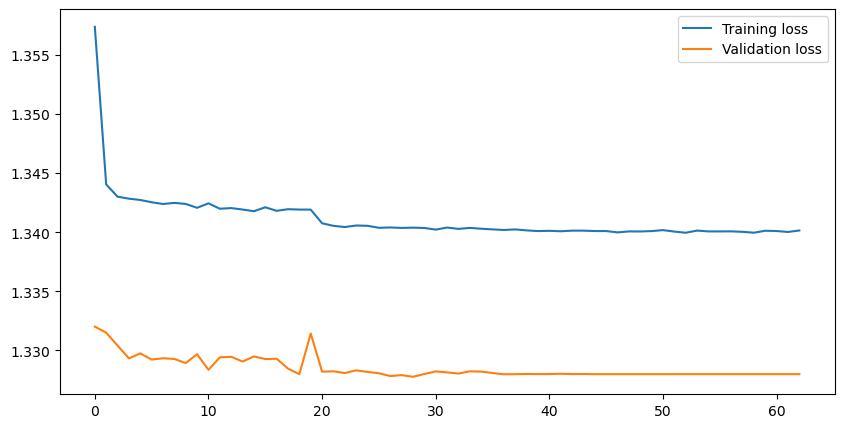

In [62]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label = 'Training loss')
plt.plot(history.history['val_loss'], label = 'Validation loss')
plt.legend()
plt.show()

In [63]:
y_pred_mixture = mdn_network.predict(x)
print(y_pred_mixture.shape)
y_pred_mixture

3855/3855 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
(123351, 60)


array([[-1.2513314 , -0.4445665 , -0.9917036 , ...,  0.11424073,
        -0.34560728, -0.65618336],
       [-1.2188326 , -0.42710635, -0.9005857 , ...,  0.11125641,
        -0.3268137 , -0.64156544],
       [-1.3898128 , -0.46804595, -0.7611257 , ...,  0.12905711,
        -0.19375762, -0.80264974],
       ...,
       [-1.3798873 , -0.34712937, -0.65104824, ..., -0.00678005,
        -0.03915533, -1.2600895 ],
       [-1.2525262 , -0.44520235, -0.8575689 , ...,  0.11989278,
        -0.2950188 , -0.6332069 ],
       [-1.4100145 , -0.45357186, -0.7636637 , ...,  0.11666241,
        -0.16801465, -0.8811903 ]], dtype=float32)

In [64]:
def split_mixture_params(params, output_dim, num_mixes):
    mus = params[: num_mixes * output_dim]
    sigs = params[num_mixes * output_dim : 2 * num_mixes * output_dim]
    pi_logits = params[-num_mixes:]
    return mus, sigs, pi_logits


def softmax(w, t=1.0):
    e = np.array(w) / t  # adjust temperature
    e -= e.max()  # subtract max to protect from exploding exp values.
    e = np.exp(e)
    dist = e / np.sum(e)
    return dist


def sample_from_categorical(dist):
    r = np.random.rand(1)  # uniform random number in [0,1]
    accumulate = 0
    for i in range(0, dist.size):
        accumulate += dist[i]
        if accumulate >= r:
            return i
    tf.logging.info("Error sampling categorical model.")
    return -1


def sample_from_output(params, output_dim, num_mixes, temp=1.0, sigma_temp=1.0):
    mus, sigs, pi_logits = split_mixture_params(params, output_dim, num_mixes)
    pis = softmax(pi_logits, t=temp)
    m = sample_from_categorical(pis)
    # Alternative way to sample from categorical:
    # m = np.random.choice(range(len(pis)), p=pis)
    mus_vector = mus[m * output_dim : (m + 1) * output_dim]
    sig_vector = sigs[m * output_dim : (m + 1) * output_dim]
    scale_matrix = np.identity(output_dim) * sig_vector  # scale matrix from diag
    cov_matrix = np.matmul(scale_matrix, scale_matrix.T)  # cov is scale squared.
    cov_matrix = cov_matrix * sigma_temp  # adjust for sigma temperature
    sample = np.random.multivariate_normal(mus_vector, cov_matrix, 1)
    return sample

In [65]:
# Sample from the predicted distributions
y_samples = np.apply_along_axis(
    sample_from_output, 1, y_pred_mixture, 1, N_MIXES, temp=1.0
)
y_samples

array([[[-0.145999  ]],

       [[ 0.88004448]],

       [[ 1.2511637 ]],

       ...,

       [[-0.5563361 ]],

       [[-1.63592754]],

       [[-1.43164902]]])

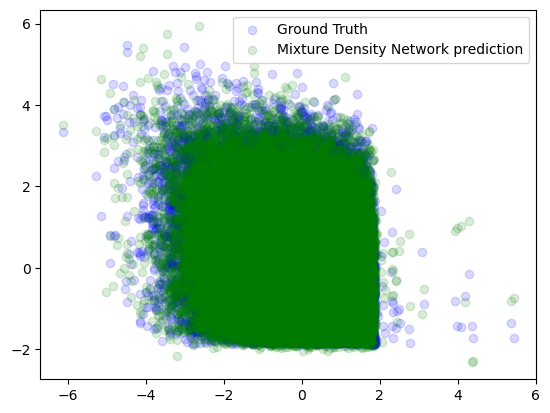

In [66]:
plt.scatter(x, y, alpha=0.15, color="blue", label="Ground Truth")
plt.scatter(
    x,
    y_samples[:, :, 0],
    color="green",
    alpha=0.15,
    label="Mixture Density Network prediction",
)
plt.legend()
plt.show()

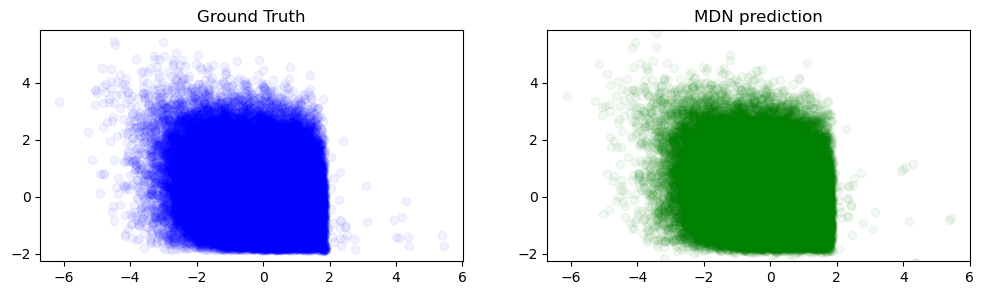

In [67]:
fig, axs = plt.subplots(1, 2)
fig.set_figheight(3)
fig.set_figwidth(12)
axs[0].set_title("Ground Truth")
axs[0].scatter(x, y, alpha=0.05, color="blue")
xlim = axs[0].get_xlim()
ylim = axs[0].get_ylim()

axs[1].scatter(
    x,
    y_samples[:, :, 0],
    color="green",
    alpha=0.05,
    label="MDN prediction",
)
axs[1].set_title("MDN prediction")
axs[1].set_xlim(xlim)
axs[1].set_ylim(ylim)
plt.show()